# COVID-19 India: A data scientist's perspective

### Imports

In [45]:
import requests
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Business Understanding

Analyzing the positive cases of Covid19 on India and how is India doing almost 3 months into down this rabbit hole? Let’s try to answer these questions by analyzing the data collected so far by covid19india.org.

### Using dataset available at covid19india.org

In [46]:
req = requests.get("https://api.covid19india.org/raw_data.json").json()
df = pd.DataFrame.from_dict(req['raw_data'])

In [47]:
df.columns

Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'estimatedonsetdate', 'gender', 'nationality', 'notes',
       'numcases', 'patientnumber', 'source1', 'source2', 'source3',
       'statecode', 'statepatientnumber', 'statuschangedate',
       'typeoftransmission'],
      dtype='object')

In [48]:
print("Shape of the dataframe : \n\trows : {}\n\tcolumns : {}\n".format(df.shape[0], df.shape[1]))
columns = df.columns
print("\nColumns present in the dataframe : {}".format(columns))

Shape of the dataframe : 
	rows : 28183
	columns : 21


Columns present in the dataframe : Index(['agebracket', 'backupnotes', 'contractedfromwhichpatientsuspected',
       'currentstatus', 'dateannounced', 'detectedcity', 'detecteddistrict',
       'detectedstate', 'estimatedonsetdate', 'gender', 'nationality', 'notes',
       'numcases', 'patientnumber', 'source1', 'source2', 'source3',
       'statecode', 'statepatientnumber', 'statuschangedate',
       'typeoftransmission'],
      dtype='object')


### Cleaning and Preparing the data


#### Dropping the columns which are not needed in the analysis


In [49]:
df = df.drop(['source1', 'source2', 'source3'], axis = 1)

#### Checking for duplicates

In [50]:
df['patientnumber'].duplicated().sum()

291

#### Although the records contain duplicate values for patient numbers but they are not actually duplicated. Looking at the data carefully, we find out that same patientnumber is used to enter a record when the status of a patient changes

In [51]:
df.dateannounced = pd.to_datetime(df['dateannounced'])

df.statuschangedate = pd.to_datetime(df['statuschangedate'])

## DATA MODELING 

In [52]:
#State wise recorvered and deceased count
status_df = df[df.detectedstate != '']
status = status_df.groupby(['detectedstate', 'currentstatus']).size().reset_index(name='count').pivot(columns='currentstatus', index='detectedstate', values='count')
status = status.fillna(0)





#Distribution of cases in States between local and fore cases
transmission_df = df[df.typeoftransmission != '']
transmission_df = transmission_df[transmission_df.typeoftransmission != 'TBD']
statewisetransmission = transmission_df.groupby(['detectedstate', 'typeoftransmission']).size().reset_index(name='count').pivot(columns='typeoftransmission', index='detectedstate', values='count')
imported_local = statewisetransmission[['Imported', 'Local']]
imported_local = imported_local.fillna(0)





#Age-Range Distribution
dropInvalidAge = lambda age : str(age).isdigit()

agebracket_df = df[df.agebracket != '']
agebracket = agebracket_df.agebracket
agebracket = agebracket[agebracket.apply(dropInvalidAge)]
floatAge = agebracket.astype(float)

age_bins = [0,20,30,40,50,60,70,80,90,100]
age_seg = pd.cut(floatAge, age_bins)

agebracketgroups = age_seg.reset_index().groupby('agebracket').size()





#Top 5 states with highest average of community spread

chain_df = df[df.contractedfromwhichpatientsuspected.str.startswith('P')]

chain_count = 0

def build_recursive_chain(patient_id) : 
    global chain_count
    if patient_id.empty : 
        return
    else :
        chain_count = chain_count + 1
        patient_id = list(patient_id)[0].replace('P', '')
        temp_df = chain_df[chain_df.patientnumber == patient_id]
        build_recursive_chain(temp_df.contractedfromwhichpatientsuspected)
        

def compute_chain(row) :
    global chain_count
    chain_count = 0
    build_recursive_chain(patient_id = pd.Series(row.contractedfromwhichpatientsuspected))
    return chain_count


chain_df_copy = chain_df.copy()
for index, row in chain_df.iterrows():
    chain_df_copy.loc[index, 'chainlength'] = compute_chain(row);
    
    
chain_group = chain_df_copy.groupby(['detectedstate'])
top_states = chain_group.mean().sort_values(by='chainlength', ascending=False)[:5]






#Gender Distribution
gender_df = df[df.gender != '']
gender = gender_df.groupby('gender').size()

gender.reset_index(name='count')


,gender,count
0,F,1766
1,M,3547


## Evaluating the Results

In [53]:
def plot_stacked_graph(data, xLabel, yLabel, title, showGrid=True) : 
    '''
    Function to plot stacked bar graph
    Input: data, xLabel, yLabel, title of the graph, flag to show grid or not (default to true)
    '''
    data.plot(kind='bar', stacked=True, figsize=(11,7))
    plt.xlabel(xLabel)
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True)
    plt.show()

### State wise recorvered and deceased count


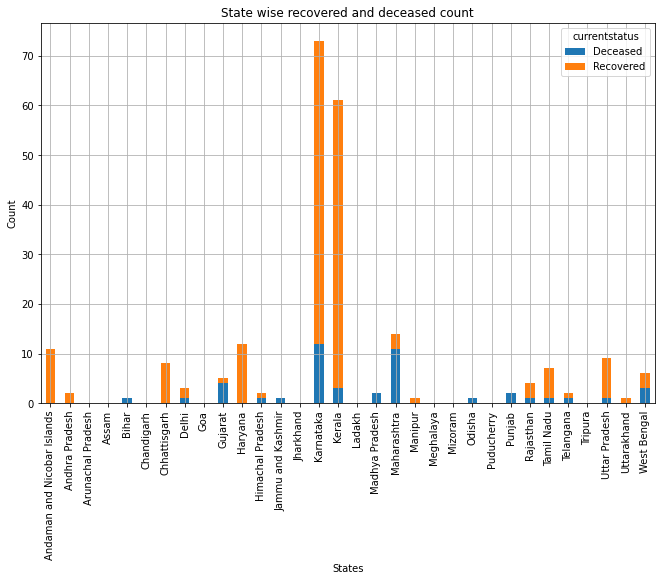

In [54]:


status = status.drop(['Migrated', 'Hospitalized'], axis = 1)
plot_stacked_graph(status, "States", "Count", "State wise recovered and deceased count", showGrid=True)

### Observation
Looking at the graph, it is quite clear that the number of recoveries is significantly higher than deaths. Well, it comes as no surprise, given the dedication with which our doctors have been working day and night.

## Distribution of cases in States between local and fore cases

##### As part of data cleaning, filling null values with zeros is what we are using here. 

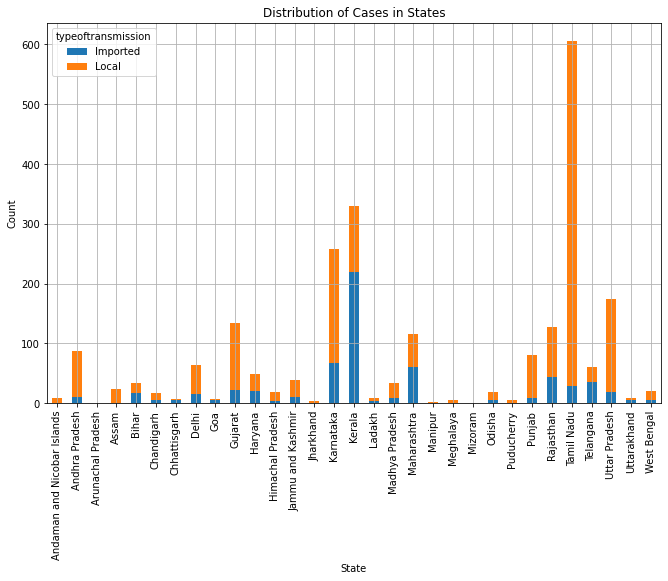

In [55]:


plot_stacked_graph(imported_local, "State", "Patient Count", "Distribution of Cases in States", showGrid=True)


### Observation

Well, this isn’t good news. As shown in the plot, the number of local cases is significantly higher than the imported cases in almost all the states.
This can only mean one thing. We have reached the community spread stage and if care is not taken moving forward, it will spread like wildfire. Which is why we need to follow social distancing, now more than ever.

In [56]:
def plotBarGraph(data, xLabel, yLabel, scale, title, showGrid=True) : 
    '''
    Function to plot bar graph
    Input: data, xLabel, yLabel, scale of y axis, title of grapb, flag to show grid or not (default as true)
    Output: none
    '''
    data.plot(kind='bar',  figsize=(15,8))
    plt.xticks(rotation=90)
    plt.xlabel(xLabel)
    plt.ylabel("Patient Count")
    plt.yscale(scale)
    plt.title(title)
    plt.grid(True)
    plt.show()

### Age-Range Distribution 

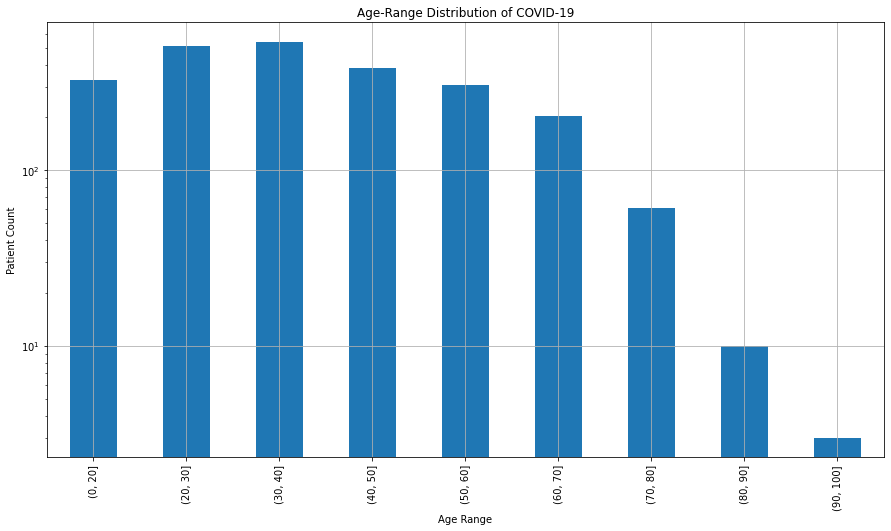

In [57]:
plotBarGraph(agebracketgroups, "Age Range", '', 'log', "Age-Range Distribution of COVID-19", showGrid=True)

### Observation
Tricenarians (30–39) and vicenarians(20–29) are the highest among those infected. People from these age groups are most actively working, hence are most prone to exposure. Knowing this, we certainly feel thankful for this state of full-lockdown currently instated in the country.

### Top 5 states with highest average of community spread

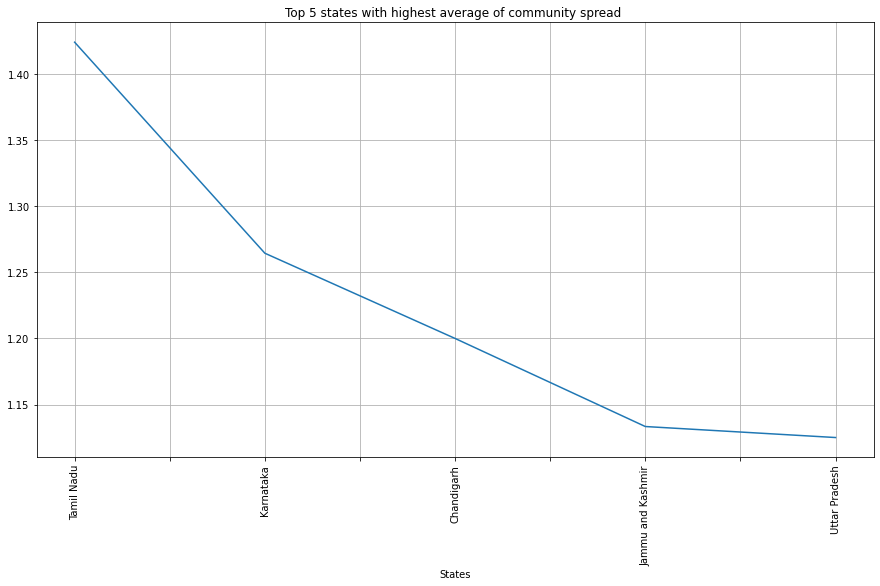

In [58]:

top_states.plot(figsize=(15,8), legend=False)
plt.xticks(rotation=90)
plt.xlabel("States")
plt.title("Top 5 states with highest average of community spread ")
plt.grid(True)
plt.show()

### Observation
That does not look good, to be honest. According to the graph, a single infected person can infect around 1.5 people. Let’s do some math around it, to see how big a problem this is.
If 1 person infects 1.5 people, and each of the infected ones again infects 1.5 people, in just 10 exchanges close to 58 people will be infected. This speaks a great deal about the severity of the issue at hand.

### Gender Distribution

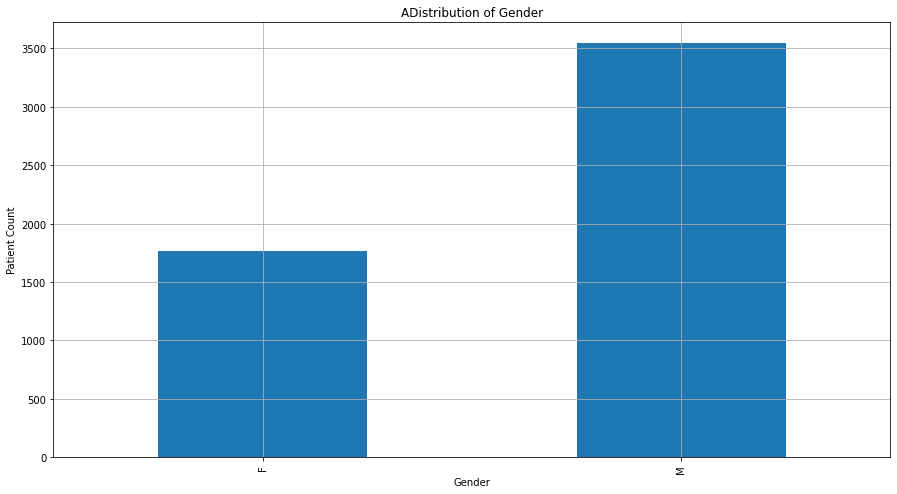

In [59]:

plotBarGraph(gender, "Gender", 'Patient Count', 'linear', "ADistribution of Gender", showGrid=True)

### Observation

Based on the graph, seems like the victim count is comprised more of males than females.


## Conclusion

### Is all hope really lost?
Not even remotely. Although certain numbers seem very frightening, let’s not forget the greatest armour that we own against COVID-19.
Yup, you guessed it. Social Distancing. It happens to be the greatest defence we have against COVID-19. While the greatest minds in the world are relentlessly working towards finding vaccines for it, let’s do our share of work by staying inside and following the lockdown mandated by the government.